### Set up the environment

In [1]:
import os 
import pandas as pd
import re
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import numpy as np
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
test_folder = '/data/training_data/test'
img_width, img_height = 224, 224
batch_size = 64

### Create the data frame

In [3]:
category_lookup = os.listdir(test_folder)
category_lookup.sort()
category_lookup = {c:str(i) for i,c in enumerate(category_lookup)}

In [14]:
test_file_paths = []

for root, sub, files in os.walk(test_folder):
    if len(files) > 0:
        test_file_paths += [os.path.join(root, file) for file in files]
        
df = pd.DataFrame({'path': test_file_paths})

In [15]:
df['category_name'] = df['path'].apply(lambda x: re.findall('/test/([a-z_]+)/', x)[0])
df['id'] = df['category_name'].apply(lambda x: category_lookup[x])
df.head()

,path,category_name,id
0,/data/training_data/test/vehicle/CA-28_08_03_2...,vehicle,11
1,/data/training_data/test/vehicle/CA-48_02_29_2...,vehicle,11
2,/data/training_data/test/vehicle/CA-17_08_03_2...,vehicle,11
3,/data/training_data/test/vehicle/CA-22_02_11_2...,vehicle,11
4,/data/training_data/test/vehicle/FL-38_04_05_2...,vehicle,11


# Model Loading and Predictions

In [6]:
# Define the model
ResNet50 = ResNet50(weights=None, include_top=False, input_shape=(img_width, img_height, 3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(ResNet50)
model.add(Flatten(input_shape=model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

# Load the pretrained weights
model.load_weights('/data/models/ResNet50/MobileNetV2_20190323_weights.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model loaded.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                3855      
Total params: 49,281,935
Trainable params: 49,228,815
Non-trainable params: 53,120
______________________________________________________________

## Generator

In [7]:
test_samples = len(df)

test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(
    df, 
    x_col='path', 
    y_col ='id', 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    shuffle=False,
    class_mode='categorical')

Found 65976 images belonging to 15 classes.


## Run Predictions

In [8]:
predictions = model.predict_generator(
    test_generator, 
    steps=test_samples//batch_size,
    verbose=True
)

1030/1030 [==============================] - 1696s 2s/step


In [127]:
# Save results
np.save(file='/data/ResNet50_preds.npy', arr=predictions)

# Evaluation

## Build Results DataFrame

In [205]:
preds = pd.DataFrame(predictions)
results_df = pd.concat([df, preds], axis=1)
results_df = results_df.dropna(axis=0)
results_df['id'] = results_df['id'].astype(int)
results_df['top_class'] = pd.Series(predictions.argmax(axis=1))
results_df['top_prob'] = pd.Series(predictions.max(axis=1))
results_df['top_1_acc'] = results_df['id'] == results_df['top_class']
results_df['top_3_classes'] = pd.Series([list(i) for i in predictions.argsort(axis=1)[:,:-4:-1]])
results_df['top_3_acc'] = results_df.apply(lambda x: x['id'] in x['top_3_classes'], axis=1)
results_df['top_5_classes'] = pd.Series([list(i) for i in predictions.argsort(axis=1)[:,:-6:-1]])
results_df['top_5_acc'] = results_df.apply(lambda x: x['id'] in x['top_5_classes'], axis=1)
results_df.to_csv('/data/ResNet50_results.csv', index=False)

## Evaluation Metrics

In [142]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
import seaborn as sns; sns.set()

In [202]:
print('Top 1 Accuracy: {:.2%}'.format(results_df['top_1_acc'].mean()))
print('Top 3 Accuracy: {:.2%}'.format(results_df['top_3_acc'].mean()))
print('Top 5 Accuracy: {:.2%}'.format(results_df['top_5_acc'].mean()))
print('F1 Score: {:.2%}'.format(f1_score(results_df['id'], results_df['top_class'], average='weighted')))
print('Precision Score: {:.2%}'.format(precision_score(results_df['id'], results_df['top_class'], average='weighted')))
print('Recall Score: {:.2%}'.format(recall_score(results_df['id'], results_df['top_class'], average='weighted')))


Top 1 Accuracy: 82.92%
Top 3 Accuracy: 96.20%
Top 5 Accuracy: 98.71%
F1 Score: 83.67%
Precision Score: 85.93%
Recall Score: 82.92%


## Categorical Breakdown

In [200]:
results_df.groupby('category_name')['top_1_acc'].mean()*100
results_df.groupby(['id', 'category_name'])['category_name'].count()

id  category_name      
0   american_black_bear    13271
1   bobcat                  3816
2   cougar                  2213
3   coyote                  3291
4   domestic_cow           15000
5   domestic_dog             112
6   elk                     3265
7   empty                  15000
8   gray_fox                1534
9   moose                   1494
10  red_fox                  258
11  vehicle                 3902
12  white_tailed_deer       2039
13  wild_turkey              654
14  wolf                      71
Name: category_name, dtype: int64

In [203]:
conf_mat = confusion_matrix(results_df['id'], results_df['top_class'])
pd.DataFrame(np.round(conf_mat/np.repeat(conf_mat.sum(axis=1), 15).reshape(15,15), 2))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.83,0.02,0.02,0.01,0.03,0.00,0.01,0.01,0.01,0.02,0.00,0.01,0.00,0.00,0.02
1,0.00,0.86,0.02,0.04,0.02,0.00,0.00,0.00,0.03,0.00,0.00,0.01,0.00,0.00,0.01
2,0.00,0.10,0.83,0.02,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.01
3,0.01,0.16,0.03,0.64,0.02,0.00,0.00,0.01,0.01,0.03,0.08,0.02,0.00,0.01,0.00
4,0.01,0.04,0.01,0.02,0.82,0.00,0.04,0.00,0.00,0.00,0.00,0.03,0.00,0.01,0.01
5,0.04,0.04,0.01,0.07,0.01,0.74,0.02,0.00,0.00,0.04,0.00,0.02,0.00,0.02,0.00
6,0.01,0.02,0.01,0.00,0.02,0.00,0.93,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
7,0.05,0.04,0.00,0.02,0.01,0.00,0.00,0.79,0.00,0.00,0.00,0.01,0.04,0.03,0.00
8,0.00,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.01
9,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.95,0.01,0.00,0.00,0.00,0.00


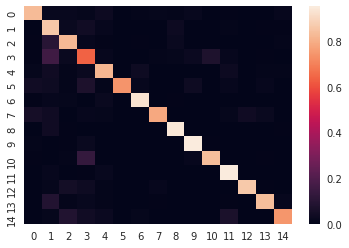

In [204]:
sns.heatmap(conf_mat/np.repeat(conf_mat.sum(axis=1), 15).reshape(15,15))